# Recurrent Neural Network

In this file, we will be adressing our take on the problem using a **recurrent neural network**.

We will begin  by importing the necessary modules:

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm # progress bar on long runs
from scipy.io import wavfile as wav
import librosa
import os
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
import keras
from keras import Sequential
from keras import regularizers as reg
from keras import layers
from sklearn.preprocessing import MinMaxScaler

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

## Data Analysis and Preprocessing

In [4]:
df = pd.read_csv('../UrbanSound8K/metadata/UrbanSound8K.csv')

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


As per mentioned in the **project statement**, the target variable corresponds to the correct labeling of the sound. There are 10 different possible sounds in the dataset:

 - air conditioner
 - car horn
 - children playing
 - dog bark
 - drilling
 - engine idling
 - gun shot
 - jackhammer
 - siren
 - street music


We can already find the `classID` column, which essentially represents each label as an integer, from 0 to 9:


In [5]:
class_id_pairs = df[['classID', 'class']].drop_duplicates().sort_values(by="classID")

for index, row in class_id_pairs.iterrows():
    print(f'classID: {row["classID"]}, class: {row["class"]}')

classID: 0, class: air_conditioner
classID: 1, class: car_horn
classID: 2, class: children_playing
classID: 3, class: dog_bark
classID: 4, class: drilling
classID: 5, class: engine_idling
classID: 6, class: gun_shot
classID: 7, class: jackhammer
classID: 8, class: siren
classID: 9, class: street_music


This means that we can remove the last column and begin working with our dataset, which we already determined is slightly unbalanced for the `car_horn` and `gunshot` values: 

In [6]:
df.drop(columns=['class'],inplace=True)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2


## Feature Extraction


The **librosa** library has a built-in method for feature extraction, called [Mel-Frequency Cepstral Coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), that summarises the frequency distribution across the time window.

In order to build the new dataset, we developed the following functions, which are capable of extracting **1D or 2D** features.

These feature extractor functions will represent the frequencies found in the wav files as **np arrays**, while using MFCCs in order to obtain features similar to the way humans perceive sounds.

In [7]:
# Uses the mean from the Time axis, uses file sample rate
def features_extractor_1D(file):
    audio, sample_rate = librosa.load(file) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) 
    return mfccs_scaled_features

# Uses both Time and Frequency axis, custom sample rate
def features_extractor_2D(file, sample_rate, path=True):
    if path: audio, _ = librosa.load(file) 
    else: audio = file
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return mfccs_features

Now that we know how to transform audio files into usable data types, we must associate each extracted numpy array to their respective entry inside the `df` dataframe.

This will allow for **important pre-processing steps** to be applied accordingly, as well as **proper Neural Network training and testing**.

## Data Preprocessing

The function below identifies files and normalizes them to be 4 seconds long for consistency.

It is capable of identifying `.wav` files with duration != 4s, and apply padding or truncating, depending on each file's issue:

In [9]:
def zero_padding(file_path, target_sr=44100, target_length=4):
    y, sr = librosa.load(file_path, sr=target_sr)
    target_samples = int(target_length * sr)
    
    if len(y) > target_samples:
        # Trim the audio to the target length
        y = y[:target_samples]
    else:
        # Pad the audio with silence to reach the target length
        padding = target_samples - len(y)
        y = np.pad(y, (0, padding), 'constant')
    return y

In order to improve dataset consistency and traning data quality, we also decided to create 2 new datasets, which we saved in pickle files in order to avoid running this code each time we needed the dataframes: 

 - `df_22`: resamples data to 22050Hz
 - `df_44`: resamples data to 44100Hz

During the development of this function, after extraction, we realized that the resulting dataframe displayed varying ranges of values.

To address this issue, we decided to apply `scaling` and `zero padding` **not to the new dataframes**, but **directly into the extracted numpy arrays**, in order to easily and efficiently improve data quality and consistency for our modeling purposes. In other words, these steps are automatically applied during the extraction process.

The group decided to use **MinMax scaling**, since it normalizes data while preserving integrity, rendering the method ideal for our Neural Network use case.

The data extraction loop has been placed inside this markdown cell, in order to prevent it from automatically running when not necessary:

---

```py
# Identify path containing all folds
audio_dataset_path='../UrbanSound8K/audio/'
extracted_features22=[]
extracted_features44=[]

scaler = MinMaxScaler(feature_range=(-1, 1))


# Iterates over all original dataframe rows (predicts approximate runtime)
for index_num,row in tqdm(df.iterrows(), total=len(df), desc="Processing", unit="row"):
    
    # Linux Version
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

    # Windows Version
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'\\',str(row["slice_file_name"]))
    
    # Adds associated sound label
    final_class_labels = row["classID"]

    y = zero_padding(file_name)

    # 22050Hz sample rate
    data1=features_extractor_2D(y, 22050, False) 
    data1_scaled = scaler.fit_transform(data1)
    extracted_features22.append([data1_scaled, final_class_labels])

    # 44100hHz sample rate
    data2=features_extractor_2D(y, 44100, False) 
    data2_scaled = scaler.fit_transform(data2)
    extracted_features44.append([data2_scaled, final_class_labels])
    
# Convert extracted_features to Pandas dataframe
df_22 = pd.DataFrame(extracted_features22,columns=['feature','class'])
df_44 = pd.DataFrame(extracted_features44,columns=['feature','class'])

# Save dataframes as pickle files
df_22.to_pickle("rnn_2d_22.pkl")
df_44.to_pickle("rnn_2d_44.pkl")
```
---

In [42]:
# Extracted data (22050Hz)
df_22 = pd.read_pickle('../rnn_2d_22.pkl')

df_22.head()

,feature,class
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...",3
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
2,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
3,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
4,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2


In [41]:
# Pickle avoids constant running of feature extraction

# Extracted data (44100Hz)
df_44 = pd.read_pickle('../rnn_2d_44.pkl')

df_44.head()

,feature,class
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.96046...",3
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
2,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
3,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
4,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2


## Avoiding common pitfalls

The original [UrbanSound8k](https://urbansounddataset.weebly.com/urbansound8k.html) website features a section outlined specifically for **cross validation**.

These rules emphasize the specific creation of 10 folds, following the identifiers present in the `fold` column from the original csv. It is explained that different folds display different levels of classification difficulty, which could potentially invalidate model efficiency if not performed correctly. 

Since both the `df_44` and `df_22` dataframes were created using the row order of the df_dataframe, we know that the `fold` column will be correctly aligned with the rest of the data. This means that we can select specific rows and assing them to their respective fold:

In [43]:
df_22['fold'] = df['fold']

df_22.head()

,feature,class,fold
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...",3,5
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
2,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
3,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
4,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5


In [44]:
df_44['fold'] = df['fold']

df_44.head()

,feature,class,fold
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.96046...",3,5
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
2,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
3,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
4,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5


## Model Development

In order to develop an effective **Recurrent Neural Network**, the group decided to explore the concept of **Long Short Term Memory** (LSTM) networks. LSTMs are a type of RNN that are designed to handle sequential data pattern recognition. 

We consider this approach could be the most effective in order to classify the sounds, since continuous sounds or repetitive rythms are sequential. These time-dependant aspects are characteristics which LSTMs are capable of recognizing and "remembering" throughout the entire training process.

LSTMs are capable of assigning weights to "remembered" features, allowing them to **balance the importance** of **older** and **more recent** information, ensuring they do not give more importance to either one.

#### Neural Network Architecture

In order to build this LSTM model, we decided to do some research and attempt to look into the topology suggested in a few published papers, before attempting to change and improve classification performance.

The [first paper](https://dergi.neu.edu.tr/index.php/aiit/article/download/740/327/3147) suggests the following:

 - 22050Hz sample rate
 - 1 LSTM layer of size 128
 - followed another LSTM layer of size 64
 - Dropout Rate = 0.2
 - SoftMax for prediction
 - 50 epochs
 - Adam optimization
 
This topology takes the large input vector size into consideration, meaning that it should maintain robustness and generally avoid major overfiting, while still allowing the model to identify patterns during an appropriate ammount of time. It also uses as sufficiently good sound quality for environment noise purposes, although we would like to verify if the difference in sound quality allows for better classification. A dropout rate of 0.2 (rate in which neurons are randomly disabled) is used in order to prevent overfitting.

Overall, this model aims for efficiency and computation speed, in an effort to reduce training time while preserving model quality and performance, hence why we chose this as our starter model topology.


[The second paper](https://annals-csis.org/Volume_18/drp/pdf/185.pdf) proposes almost identical topology (similar to most of the projects found), with the small changes of:
 - 44100Hz sample rate
 - Dropout Rate = 0.25
 - 64 epochs

We expect this model to take longer to train (due to the higher number of epochs).
It could lead to overfitting, which is why the **dropout rate** has also been **adjusted** to the slightly higher value of 0.25. If it is correctly trained, it **should demonstrate better results**, compared to the previous settings.

Overall, it is a generally "riskier" model, and it was chosen to assess if the results of the combination of **increase in epochs** and **improved sound quality** could compensate the time consumed, render the training problems relativelly irrelevant if the generalization and classification abilities of the resulting model show significant improvements.

# NEEDS REVISION

### Model Performance Predictions


We expect the **first model** to be trained faster due to inferior sound quality and lower epochs, in contrast with the **second model**, which could overfit but benefits from higher sound quality and dropout rate, potentially mitigating such problems, overall being preferable.

Both results will be used as a type of foundation for the final topology decisions.

### Model Generation

Following the previously stated network topology and parameters, and using the available **tensorflow** and **keras** modules, we can start implementing an LSTM neural network, using available tools like:

 - `keras.Sequential()`
 - `layers.LSTM` 
 - `layers.Dropout`
 - `layers.TimeDistributed`
 - `layers.Dropout`

We have created a Neural Network generating function, which is based on the following concepts: 

 - By ensuring that the input has a fixed shape and frequency, we can now use a Sequential keras model. This will allow for simple layer stacking and parameter configuration;
 - A dropout rate of 0.2 is employed in between each layer (with the exception of flatten and classification layers);
 - Time Distributed layers allow for easier handling of the extracted sequential features, by preserving the sequential time dependant features while reducing dimensionality;
 - In order to potentially improve our classifier's robustness, we decided to employ **l2 regularization** (or Lasso regularization), due to our dataset's reduced size;



In [45]:
# Easily configurable to generate with different architecture
# Implicitly creates first model, explained above

def generate_lstm(train_shape, lstm1_size=128, lstm2_size=64, dropout=0.2, regularization=reg.l2(0.01)):
    # Initiaizes sequential model
    model = Sequential()

    # Adds 2 LSTM layers of size 128 and 64, with a dropout rate of 0.2
    model.add(layers.LSTM(lstm1_size,  input_shape = train_shape, return_sequences = True, activation='tanh'))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(lstm2_size, return_sequences = True, activation='tanh'))
    model.add(layers.Dropout(dropout))

    # Suggested intermediate dense layer -> reduce dimensionality and preserve time sequential features
    model.add(layers.TimeDistributed(layers.Dense(64, activation='tanh', kernel_regularizer = regularization)))
    model.add(layers.Dropout(dropout))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='tanh', kernel_regularizer = regularization)))
    model.add(layers.Dropout(dropout))

    # Last TimeDistributed produces 16 features/time step (thought dimensionality was appropriate)
    model.add(layers.TimeDistributed(layers.Dense(16, activation='tanh', kernel_regularizer = regularization)))
    model.add(layers.Dropout(dropout))

    # Flattens the last TimeDistributed outputs
    model.add(layers.Flatten())

    # Dense output layer -> classification
    model.add(layers.Dense(10, activation = 'softmax'))

    return model

## Data Splitting

In order to define X and y while respecting the UrbanSound8k website indications, we need to use 9 folds for building (X_train, y_train) and the remaining fold as for building (X_test, y_test), in the 10 different possible ways. 

In [47]:
def train_test_split(df, i, values_log=False, full_log=False,):
    # Rows where "fold" is not i -> different training combinations
    train_dataframe = df[df["fold"] != i]  
    
    # Rows where "fold" is i -> different testing combinations
    test_dataframe = df[df["fold"] == i]  

    # Split the dataset into training features and class
    X_train = np.array(train_dataframe['feature'].tolist())
    y_train = np.array(train_dataframe['class'].tolist())

    # Split the dataset into testing features and class
    X_test = np.array(test_dataframe['feature'].tolist())
    y_test = np.array(test_dataframe['class'].tolist())

    # Labels must be one hot encoded for the LSTM output layer
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes=10)
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes=10)


    # Outputs detailed information
    if full_log: 
        print(f"Test folder: {i}")
        print(f"X_train shape: {X_train.shape} - (Samples: {X_train.shape[0]}, Time Steps: {X_train.shape[1]}, Features: {X_train.shape[2]})")
        print(f"y_train shape (before encoding): {y_train.shape} - (Samples: {y_train.shape[0]})")
        print(f"y_train_encoded shape (after encoding): {y_train_encoded.shape} - (Samples: {y_train_encoded.shape[0]}, Classes: {y_train_encoded.shape[1]})")
        print(f"X_test shape: {X_test.shape} - (Samples: {X_test.shape[0]}, Time Steps: {X_test.shape[1]}, Features: {X_test.shape[2]})")
        print(f"y_test shape (before encoding): {y_test.shape} - (Samples: {y_test.shape[0]})")
        print(f"y_test_encoded shape (after encoding): {y_test_encoded.shape} - (Samples: {y_test_encoded.shape[0]}, Classes: {y_test_encoded.shape[1]})")
        print("-" * 85)

    # Outputs simple information
    elif values_log:
        print(f"X_train: {X_train.shape}")
        print(f"y_train_encoded: {y_train_encoded.shape}")
        print(f"X_test: {X_test.shape}")
        print(f"y_test_encoded: {y_test_encoded.shape}")
        print("-" * 85)

    return X_train, y_train_encoded, X_test, y_test_encoded


Let's visualize our train and test data shapes for every combination:

In [14]:
for i in range(1,11):
    X_train, y_train, X_test, y_test = train_test_split(df_44, i, values_log=True)

X_train: (7859, 40, 345)
y_train_encoded: (7859, 10)
X_test: (873, 40, 345)
y_test_encoded: (873, 10)
-------------------------------------------------------------------------------------
X_train: (7844, 40, 345)
y_train_encoded: (7844, 10)
X_test: (888, 40, 345)
y_test_encoded: (888, 10)
-------------------------------------------------------------------------------------
X_train: (7807, 40, 345)
y_train_encoded: (7807, 10)
X_test: (925, 40, 345)
y_test_encoded: (925, 10)
-------------------------------------------------------------------------------------
X_train: (7742, 40, 345)
y_train_encoded: (7742, 10)
X_test: (990, 40, 345)
y_test_encoded: (990, 10)
-------------------------------------------------------------------------------------
X_train: (7796, 40, 345)
y_train_encoded: (7796, 10)
X_test: (936, 40, 345)
y_test_encoded: (936, 10)
-------------------------------------------------------------------------------------
X_train: (7909, 40, 345)
y_train_encoded: (7909, 10)
X_test:

## Model Performance

The LSTM's input dimensions are determined by the shape of our data. As you can confirm in the print statement above, our shapes' first index are not constant in each fold, but they display a consistent structure:

  - `batch_size`: Number of samples in the set (7859, 7844...)
  - `time_steps`: Number of time steps in the data (always 40)
  - `n_features`: Number of features at each time step (always 345)

Furthermore, we must build our model using the following:

  - **input_shape** = (time_steps, n_features)

Which directly corresponds to:

In [15]:
input_shape = (40, 345)

And creates models with the following architecture:

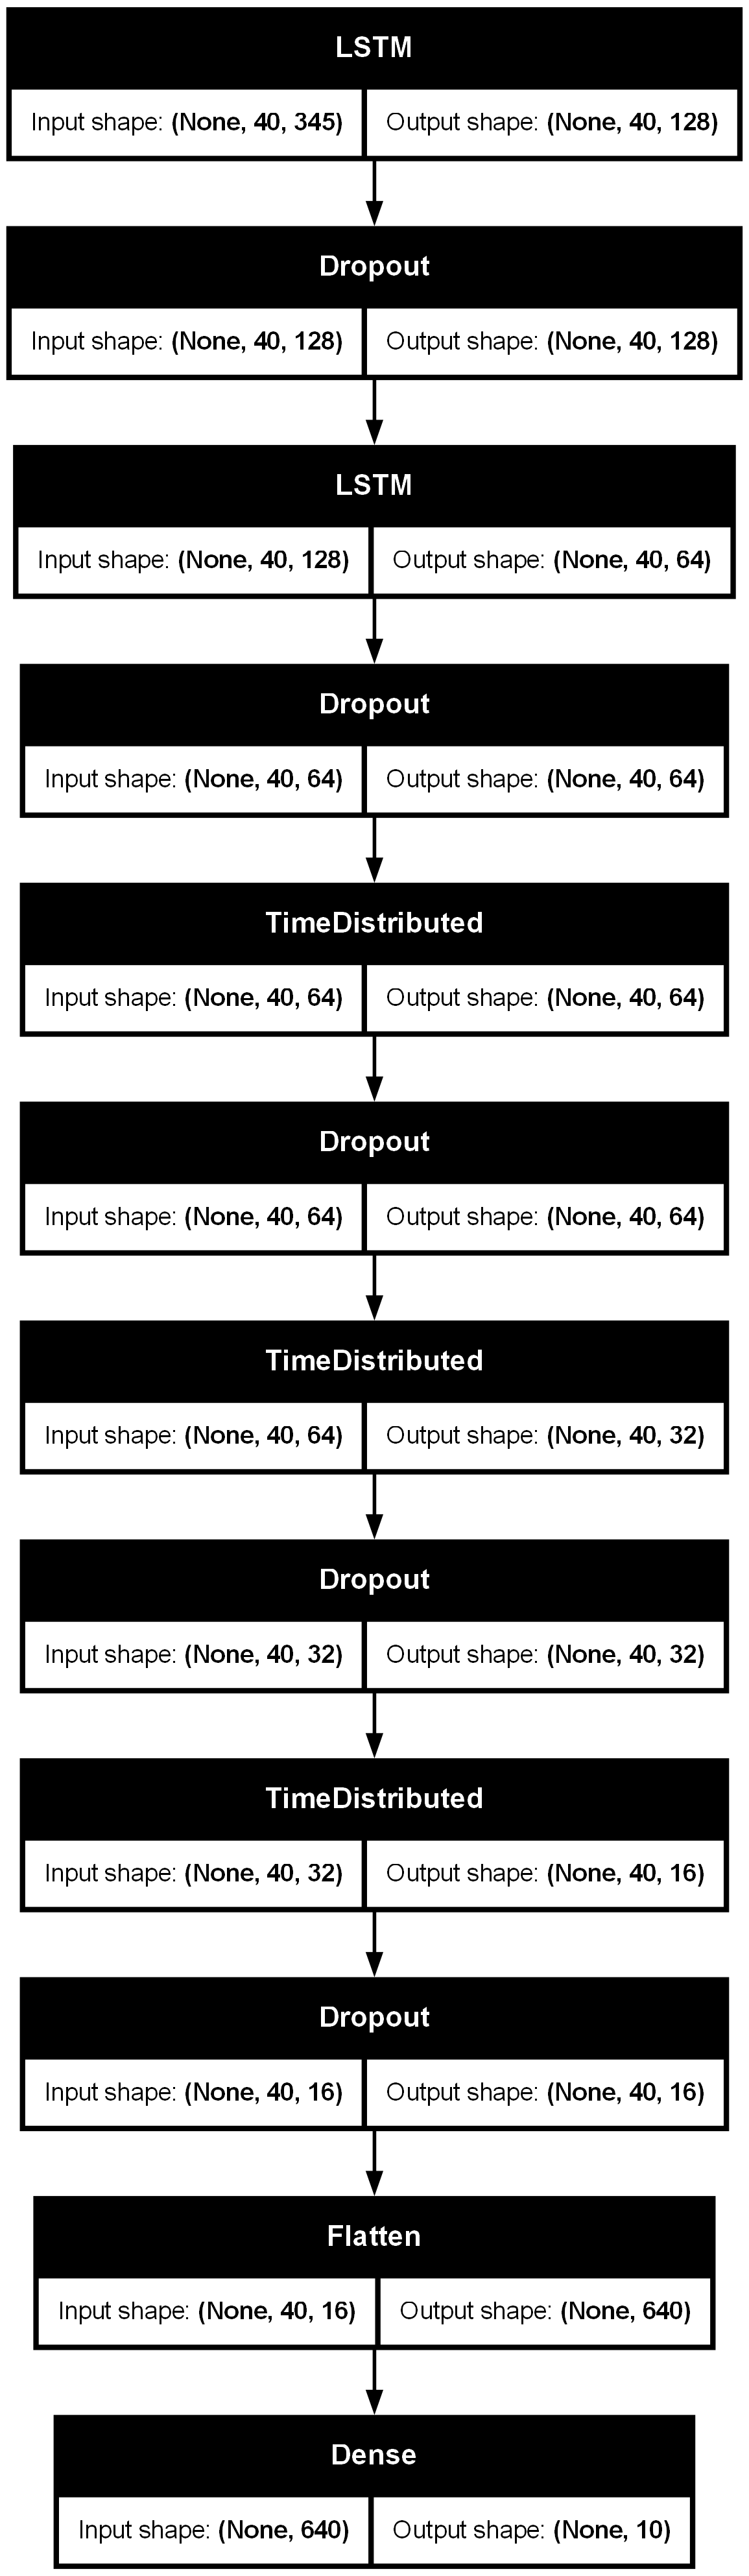

In [16]:
model_for_image = generate_lstm(input_shape)

keras.utils.plot_model(model_for_image, "model.png", show_shapes=True)

In order to facilitate the testing different neural network architectures, we decided to build an easily customizable function that returns useful data:

In [48]:
def test_model(dataframe, input_shape=(40,345), epochs=50, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
    
    # Stores accuracy values, with each index
    # corresponding to fold (i) - 1
    accuracy = []

    # Test for every combination possible
    for i in range(1,11):

        # Defines train-test split
        X_train, y_train, X_test, y_test = train_test_split(dataframe, i)

        # Creates fresh model
        model = generate_lstm(input_shape)

        # Compiles the model
        model.compile(optimizer = optimizer,
                      loss = loss, 
                      metrics = metrics) 

        # Trains the model
        epoch_metrics_data = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = epochs)  

        # Evaluates model performance
        results = model.evaluate(X_test, y_test, verbose=0)
        fold_accuracy = results[1] 

        accuracy.append(fold_accuracy)

    return accuracy


### First Model

This model will use the architecture outlined in the first paper:

In [50]:
accuracy = test_model(df_44, input_shape, 1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.1810 - loss: 3.1962 - val_accuracy: 0.2692 - val_loss: 2.3477
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.1932 - loss: 3.1885 - val_accuracy: 0.3243 - val_loss: 2.3674
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.1836 - loss: 3.1519 - val_accuracy: 0.2573 - val_loss: 2.5444
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.1949 - loss: 3.1418 - val_accuracy: 0.2081 - val_loss: 2.6349
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2074 - loss: 3.1470 - val_accuracy: 0.1250 - val_loss: 2.7321
248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.1867 - loss: 3.1220 - val_accuracy: 0.2843 - val_loss: 2.3024
247/247 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.1851 - loss: 3.1734 - val_accuracy: 0.2733 - val_loss: 2.4456
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.1899 - loss: 3.1423 - val_accuracy: 0.2171 - val_loss: 2.4338
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - acc

In [51]:
print(accuracy)

[0.26918670535087585, 0.3243243098258972, 0.2572973072528839, 0.20808081328868866, 0.125, 0.28432562947273254, 0.2732696831226349, 0.21712158620357513, 0.23284313082695007, 0.21983273327350616]



Final Metrics Across All Folds:
Average Accuracy: 0.2411
Accuracy Standard Deviation: 0.0515


TypeError: object of type 'float' has no len()

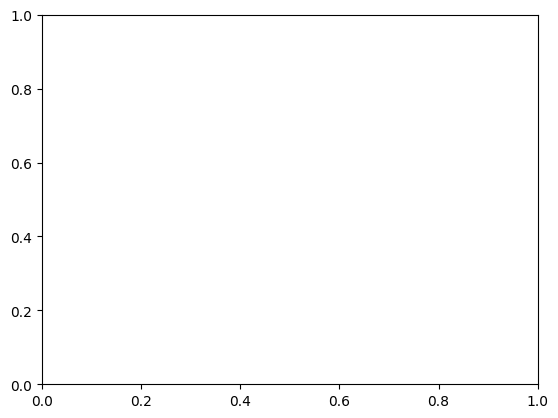

In [ ]:
# Compute required metrics
avg_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)

# Print metrics
print("\nFinal Metrics Across All Folds:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Accuracy Standard Deviation: {std_accuracy:.4f}")

# Boxplot for accuracy across all folds


# References

Introduction to Extraction of Data from the UrbanSound8k dataset - [part1](https://www.youtube.com/watch?v=mHPpCXqQd7Y), [part2](https://www.youtube.com/watch?v=4F-cwOkMdTE)

Many-to-Many LSTM for Sequence Prediction with TimeDistributed layers - [link](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)

